# Goal

The plan for this notebook is to go through and arrange a basic dataset containing all of the many sources I've pulled through, morganize them all with mutual fields of message, source, and of course its rank.
    Ultimately I just settled on using Berkley's data. However, there is a possibility of combining others later.


The current plan is to make a multiclass classification of 'harmless', 'reprimanded', and 'immediate intervention'. Such terms are vague and need to be defined, however for right now they're sufficient. I'll likely nicknake them as 0, 1, and 2. To accomodate for future changes in methodology and classification, I'll keep whatever their original label is.

A secondary goal is to take note of potential features to be used, specifically from the original dataset (such as the second's specification on what type of harassment ie anti-Semetic).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Warning:

This notebook too works with a dataframe not currently provided for in the code. If you're that curious feel free to download the big one from Berkeley then run this notbook. Pragmatically, start with eda_i.ipynb.

In [2]:
df = pd.read_csv('../data/02_MeasuringHateSpeech.csv') #Originally called something else, yet for the sake of organizing
#all the data I was connsidering of using I changed it to this.
#Note that I'm inclined to comment out potentially all of this notebook as this file is quite big and I don't think it can be
#uploaded to git.
df =df.drop(columns=['Unnamed: 0'])
print(df.shape)
df.head()

(135556, 131)


,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [7]:
df.columns[df.isnull().sum()>0] #Eh, spoiler alert - we'll be deleting these anyways... not getting into those details.

Index(['annotator_educ', 'annotator_income', 'annotator_ideology',
       'annotator_age'],
      dtype='object')

In [3]:
39565*7912*10/1_000_000 #Unsue where '1.35m total labels' come from, but eh...

3130.3828

In [4]:
i= -10 #Starting to explore some of the column names. Likely will some of interest more foromally later.
i += 10
df.columns[i:i+10]

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence'],
      dtype='object')

In [5]:
i += 10
df.columns[i:i+10]

Index(['genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text',
       'infitms', 'outfitms', 'annotator_severity', 'std_err',
       'annotator_infitms'],
      dtype='object')

In [6]:
i += 10
df.columns[i:i+10]

Index(['annotator_outfitms', 'hypothesis', 'target_race_asian',
       'target_race_black', 'target_race_latinx', 'target_race_middle_eastern',
       'target_race_native_american', 'target_race_pacific_islander',
       'target_race_white', 'target_race_other'],
      dtype='object')

So, we see quite a thorough job re. disclosing any potentail biases as well as nuanced data in general. Likely we could think of more to comment on, such as the presence of emojis or urls and how that affects the hate_speech_score, however this is more than eough. Momentarily we'll prune the database as at least the annotator details I do not want to deal with.

In [7]:
len(df['comment_id'].unique())

39565

In [8]:
#So, we have to simplify this dataset. Pragmatically, I see two things to promptly take care of:
#1 simplifaction by annonators. We'll go with a simple average.
#2 Ignoring, going forward, the various biographical details of each annotator.
    #Now, while it would be interest in doing an average such things become so murky... plus, I would hope language is
    #explicit enough that in the category of most 'interest', the 'immediate action' category would be attended to...

df.groupby('comment_id')['hate_speech_score'].agg(['count', 'mean'])[:5]

,count,mean
comment_id,,
1,4,0.46
2,3,0.03
3,3,-1.29
4,2,-0.24
5,3,-2.84


In [9]:
#Hmm, first we'll need to do a similar thing re. the variosu targts. ie:
for i in df.columns:
    if df[i].dtypes == 'bool':
        df[i] = df[i].astype(int)

In [10]:
targets = list(df.columns[list(df.columns.str.contains('target'))]) #Heh, they actaully are targets in this case.
print(len(targets))
targets[:7] #Recall the seven major targets revolve around: race, religiion, origin, gender, sexuality, age, and disability

53


['target_race_asian',
 'target_race_black',
 'target_race_latinx',
 'target_race_middle_eastern',
 'target_race_native_american',
 'target_race_pacific_islander',
 'target_race_white']

In [11]:
#Hmm, pragmatically we'll be taking the mean of so many guys. First of all, we'll be lobbing off the anotators.

In [12]:
annotators = list(df.columns[list(df.columns.str.contains('annotator'))])
annotators.remove('annotator_id') #As we may still use this when we combine scors and the like.
print(len(annotators))
annotators[:5]

59


['annotator_severity',
 'annotator_infitms',
 'annotator_outfitms',
 'annotator_gender',
 'annotator_trans']

In [13]:
df = df.drop(columns=annotators, axis=1)
df.shape#59 less- a start.

(135556, 72)

In [14]:
df.columns #A bit moe manegable. Pragmatically we'll have to keep the targets at least for now. Likely they won't end us
#being useful as features, as whether the main group or a nickname is used the word token synergy remains the same... plus it
#does seem a bit artificial to double up their value. Plus, we wouldn't be using them in the final model of parsing children's
#social media accounts.... one thing word count factor, which would be engineered at the like, but these??

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide',
       'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms',
       'outfitms', 'std_err', 'hypothesis', 'target_race_asian',
       'target_race_black', 'target_race_latinx', 'target_race_middle_eastern',
       'target_race_native_american', 'target_race_pacific_islander',
       'target_race_white', 'target_race_other', 'target_race',
       'target_religion_atheist', 'target_religion_buddhist',
       'target_religion_christian', 'target_religion_hindu',
       'target_religion_jewish', 'target_religion_mormon',
       'target_religion_muslim', 'target_religion_other', 'target_religion',
       'target_origin_immigrant', 'target_origin_migrant_worker',
       'target_origin_specific_country', 'target_origin_undocumented',
       'target_origin_other', 'target_origin', 'target_gender_men',
       'target_gender_non_bi

In [15]:
df.dtypes[:20]

comment_id             int64
annotator_id           int64
platform               int64
sentiment            float64
respect              float64
insult               float64
humiliate            float64
status               float64
dehumanize           float64
violence             float64
genocide             float64
attack_defend        float64
hatespeech           float64
hate_speech_score    float64
text                  object
infitms              float64
outfitms             float64
std_err              float64
hypothesis           float64
target_race_asian      int32
dtype: object

In [16]:
df['platform'].value_counts() #A potential feature to go through. Note that I unfortunately never found in the documentation
#clear distinction of what's: Youtube, Twitter, and Reddit. Furthermore, what is this fourth group?!!?

platform
1    43227
0    37164
2    35027
3    20138
Name: count, dtype: int64

In [17]:
df.groupby('comment_id')['text'].describe()

,count,unique,top,freq
comment_id,,,,
1,4,1,White people are trash.,4
2,3,1,"You've caught the big gay, it's known to be ai...",3
3,3,1,"I'm not saying you said that, I'm just saying ...",3
4,2,1,Donald Trump. Yeet myself off a building onto ...,2
5,3,1,Fabrice Fabrice is ostensibly black or black/l...,3
...,...,...,...,...
50066,4,1,Good you Americans are annoying asf. I Wish mo...,4
50067,1,1,Go to streets of the USA and our kids and vets...,1
50068,2,1,That Kenyan girl is gorgeous!,2


In [18]:
df[df['comment_id']==1].iloc[:5,:12] #I'll do ab it of base EDA now:#So, we have 4 people commenting in this example:
#Hmm, now that I'm considering things, it could be useful to keep any one metric to consider styles. Ie violence vs genocide.
#However, such a thing would be incredibly hard to predict, per current restraints.Especialy when anyways our target is
#hate speech score -> category, focusing on such things would be too difficult and lengthy and likely most importantly
#a digression from our aim. I'll get rid of those - hatespeech. I'll also get rid of inftims and outfitsm and std error
#and hypothesis.

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend
1064,1,3330,0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,0.0,3.0
23298,1,962,0,4.0,4.0,3.0,2.0,3.0,3.0,0.0,0.0,4.0
50410,1,8185,0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0
70119,1,712,0,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0,3.0


In [19]:
df[df['comment_id']==1].iloc[:5,12:20]

,hatespeech,hate_speech_score,text,infitms,outfitms,std_err,hypothesis,target_race_asian
1064,0.0,0.46,White people are trash.,0.73,0.68,0.3,0.0333,0
23298,0.0,0.46,White people are trash.,0.73,0.68,0.3,0.0333,0
50410,0.0,0.46,White people are trash.,0.73,0.68,0.3,0.0333,0
70119,0.0,0.46,White people are trash.,0.73,0.68,0.3,0.0333,0


In [20]:
df['hatespeech'].value_counts() #Hmm, I am quite unsure what this is... honestly per my intentions I don't really care
#(I'm honestly much more interested at least starting out doing my own thing...)

hatespeech
0.0    80624
2.0    46021
1.0     8911
Name: count, dtype: int64

In [21]:
df[df['hatespeech']==1]['hate_speech_score'].describe() #Yeah, I have no idea what the difference is. Likely could figure
#it out if I were to explore more...but I don't really care to at the moment.
#Note that a similar distribution also is true for 0 and 2.

count    8911.000000
mean       -0.114270
std         1.600488
min        -6.850000
25%        -1.160000
50%        -0.050000
75%         1.025000
max         5.090000
Name: hate_speech_score, dtype: float64

In [22]:
#Continuing with comment_id==1 exploration:

df[df['comment_id']==1].iloc[:5,20:30] #Then a bunch of booleans... note that the overall categories of whatever
#targeted hate speech is in the same structure. Likely multiple are possible, however htat is not our concern/focus at the moment.

,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist
1064,0,0,0,0,0,1,0,1,0,0
23298,0,0,0,0,0,1,0,1,0,0
50410,0,0,0,0,0,1,0,1,0,0
70119,0,0,0,0,0,1,0,1,0,0


In [23]:
sprucing_i = list(df.columns[3:19])
print(len(sprucing_i))
sprucing_i.remove('hate_speech_score')
sprucing_i.remove('text')
df = df.drop(columns=sprucing_i, axis=1)
print(df.shape)
df.head()

16
(135556, 58)


,comment_id,annotator_id,platform,hate_speech_score,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,47777,10873,3,-3.90,Yes indeed. She sort of reminds me of the elde...,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,39773,2790,2,-6.52,The trans women reading this tweet right now i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,47101,3379,3,0.36,Question: These 4 broads who criticize America...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,43625,7365,3,0.26,It is about time for all illegals to go back t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12538,488,0,1.54,For starters bend over the one in pink and kic...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df.groupby('comment_id')['hate_speech_score'].mean()

comment_id
1        0.46
2        0.03
3       -1.29
4       -0.24
5       -2.84
         ... 
50066    2.05
50067    0.74
50068   -4.28
50069    0.81
50070    2.43
Name: hate_speech_score, Length: 39565, dtype: float64

In [25]:
for i in df.columns:
    if 'target' in i:
        df[i] = df[i].astype(int)
df.head()

,comment_id,annotator_id,platform,hate_speech_score,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,47777,10873,3,-3.90,Yes indeed. She sort of reminds me of the elde...,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,39773,2790,2,-6.52,The trans women reading this tweet right now i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,47101,3379,3,0.36,Question: These 4 broads who criticize America...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,43625,7365,3,0.26,It is about time for all illegals to go back t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12538,488,0,1.54,For starters bend over the one in pink and kic...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## The Start of a Cleaned Data Frame

All right, now we should condense them, getting ready to prep the dataframe we'll actually use. Unfortunately, I find
the current code quite rough, however I will keep it for now.

In [26]:
data = pd.DataFrame(data={
    'comment_id':df['comment_id']
    ,'platform':df['platform']
    ,'text':df['text']
})
print(data.shape)
data.head()

(135556, 3)


,comment_id,platform,text
0,47777,3,Yes indeed. She sort of reminds me of the elde...
1,39773,2,The trans women reading this tweet right now i...
2,47101,3,Question: These 4 broads who criticize America...
3,43625,3,It is about time for all illegals to go back t...
4,12538,0,For starters bend over the one in pink and kic...


In [27]:
data = data.drop_duplicates().sort_values('comment_id')
data = data.reset_index(drop=True)
data.head()

,comment_id,platform,text
0,1,0,White people are trash.
1,2,0,"You've caught the big gay, it's known to be ai..."
2,3,0,"I'm not saying you said that, I'm just saying ..."
3,4,0,Donald Trump. Yeet myself off a building onto ...
4,5,0,Fabrice Fabrice is ostensibly black or black/l...


In [28]:
sprucing_ii = ['platform', 'text']
df = df.drop(columns=sprucing_ii, axis=1)
df.head()

,comment_id,annotator_id,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
0,47777,10873,-3.90,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,39773,2790,-6.52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,47101,3379,0.36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,43625,7365,0.26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12538,488,1.54,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
focus = df.groupby('comment_id')[df.columns[2:]].mean()
focus.head()

,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
comment_id,,,,,,,,,,,,,,,,,,,,,
1,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
i = 0

In [32]:
#To confirm a few first:
i +=1
df[df['comment_id']==i]

,comment_id,annotator_id,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
1064,1,3330,0.46,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
23298,1,962,0.46,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
50410,1,8185,0.46,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
70119,1,712,0.46,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
data.head() #I guess better late than never, but interesting that 10k comments are 'missing'... unsure why that is. Regardless, we have almost 40k unique comments.

,comment_id,platform,text
0,1,0,White people are trash.
1,2,0,"You've caught the big gay, it's known to be ai..."
2,3,0,"I'm not saying you said that, I'm just saying ..."
3,4,0,Donald Trump. Yeet myself off a building onto ...
4,5,0,Fabrice Fabrice is ostensibly black or black/l...


In [34]:
data = data.set_index('comment_id')

In [35]:
final = pd.concat([data, focus], axis=1) #Once again, a bit too rough for my likings. However, we got the job done.
final.head()

,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
comment_id,,,,,,,,,,,,,,,,,,,,,
1,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
i = 2 #Exploring a bit of the target distrubutions

In [37]:
i += 1 
final[final.columns[i]].value_counts(normalize=True)

target_race_asian
0.000000    0.940806
1.000000    0.019007
0.500000    0.014280
0.333333    0.012081
0.250000    0.006218
0.666667    0.004802
0.750000    0.001137
0.200000    0.000303
0.800000    0.000051
0.600000    0.000051
0.568878    0.000025
0.031447    0.000025
0.001555    0.000025
0.002532    0.000025
0.003937    0.000025
0.920596    0.000025
0.019108    0.000025
0.002494    0.000025
0.008230    0.000025
0.028926    0.000025
0.002653    0.000025
0.015365    0.000025
0.001335    0.000025
0.743280    0.000025
0.004172    0.000025
0.020942    0.000025
0.005797    0.000025
0.006739    0.000025
0.022928    0.000025
0.001385    0.000025
0.004249    0.000025
0.003817    0.000025
0.050179    0.000025
0.002528    0.000025
0.003125    0.000025
0.005089    0.000025
0.050441    0.000025
0.166667    0.000025
0.272160    0.000025
0.001284    0.000025
0.005348    0.000025
0.001678    0.000025
0.922111    0.000025
0.001276    0.000025
0.006410    0.000025
0.001227    0.000025
0.002688    0.00

In [38]:
#Yeah, this will be are first base we work off of. We'll do a bit more EDA first though
#Once again, here are the platforms:
final['platform'].value_counts(normalize=True)

platform
0    0.400404
2    0.391129
3    0.206698
1    0.001769
Name: proportion, dtype: float64

In [39]:
final['hate_speech_score'].describe()

count    39565.000000
mean        -0.943911
std          2.073087
min         -8.340000
25%         -2.330000
50%         -0.700000
75%          0.570000
max          6.300000
Name: hate_speech_score, dtype: float64

In [40]:
#One other 'neutral' thing first:
final.groupby('platform')['hate_speech_score'].describe() #The big hree should toutube, twitter,and reddit.UNsure what that
#very small 1 group is. Pragmatically, reddit is likely 3 as it's smaller - and the vibe I got from their paper was that as well.

#Unsure re. the others which is which. Regardless:

#0 follows the general trend quite well.
#1 is negligible. I mght evn drop it; plus, notice how much toxic its dstribution is overall...
#2 is somewhat to the left, being more benign in general than 0/averag, however not by much.
#3, presumably Reddit, is unsurprisingly slightly more, if any of them would be, toxic than the others. THe reason why
#I'd assume this is given the nature of the platforms for Reddit being a place meant to formally talk about things; as opposed
#to Youtube commnts which are by their nature shorter.I'm unfamiliar with Twitter,b ut hte vibe I get is that it is also
#meant for briefer messages.

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
0,15842.0,-0.934302,2.155796,-8.34,-2.44,-0.70,0.68,6.01
1,70.0,0.143714,2.624843,-5.43,-1.88,1.37,2.13,3.91
2,15475.0,-1.079380,2.027314,-8.28,-2.42,-0.82,0.39,6.09
3,8178.0,-0.715489,1.964120,-8.07,-1.94,-0.48,0.67,6.30


In [ ]:
#Hmm, I guess we could go look at the individual distributions of each 'target' hate. Eh, but we won't. Maybe later.

In [41]:
#Howeve, I do insist in already seeing how each target relates to the hate speech score:
    #Later I would be interested if a group gets hated n more in one place.
    
def scatter_looker(df, target_col_no):
    cluster, remainder = len(df.columns)//4, len(df.columns)%4
    if remainder > 0:
        cluster += 1
    target_name = df.columns[target_col_no]
    #target_plot = 'scatter'
    
    for i in range(cluster):
        unit = i * 4
        print(f"Plots for the {i} cluster:")
        
        plt.figure(figsize = (16,9))
        print(f"Scatterplots for {target_name}:")
        try:
            ax1 = plt.subplot(2, 2, 1)
            ax1.scatter(df[df.columns[target_col_no]], df[df.columns[unit+0]])
            cur_corr = round(df[df.columns[target_col_no]].corr(df[df.columns[unit+0]]),3)
            ax1.set_title(f"vs. {df.columns[unit+0]}, the {unit+0}th column. with a correlation of: {cur_corr}")
        except:
            ax1 = plt.subplot(2, 2, 1)
            ax1.set_title(f"vs. {df.columns[unit+0]}, theoretically.")
        
        if df.dtypes[unit+1] != 'object':
            try:
                ax2 = plt.subplot(2, 2, 2)
                ax2.scatter(df[df.columns[target_col_no]], df[df.columns[unit+1]])
                cur_corr = round(df[df.columns[target_col_no]].corr(df[df.columns[unit+1]]),3)
                ax2.set_title(f"vs. {df.columns[unit+1]}, the {unit+1}th column. with a correlation of: {cur_corr}")
            except:
                ax2 = plt.subplot(2, 2, 2)
                ax2.set_title(f"vs. {df.columns[unit+1]}, theoretically.")
        
        try:
            ax3 = plt.subplot(2, 2, 3)
            ax3.scatter(df[df.columns[target_col_no]], df[df.columns[unit+2]])
            cur_corr = round(df[df.columns[target_col_no]].corr(df[df.columns[unit+2]]),3)
            ax3.set_title(f"vs. {df.columns[unit+2]}, the {unit+2}th column. with a correlation of: {cur_corr}")
        except:
            pass
        
        try:
            ax4 = plt.subplot(2, 2, 4)
            ax4.scatter(df[df.columns[target_col_no]], df[df.columns[unit+3]])
            cur_corr = round(df[df.columns[target_col_no]].corr(df[df.columns[unit+3]]),3)
            ax4.set_title(f"vs. {df.columns[unit+3]}, the {unit+3}th column. with a correlation of: {cur_corr}")
        except:
            pass
        
        plt.tight_layout();
        print('`'*26)
        print('`'*26)
#     while remainder > 0:
#         plt.figure(figsize = (16,9))
#         #Not as elegant, but it'll get the job done easly.
#         plt.scatter(df[df.columns[target_col_no]], df[df.columns[unit+0]])
#         plt.set_title(f"{target_name} vs. {df.columns[unit+0]}");
#         print('`'*26)
#         print('`'*26)
#         remainder -= 1

Plots for the 0 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 1 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 2 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 3 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 4 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 5 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 6 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 7 cluster:
Scatterplots for hate_speech_score:
``````````````````````````
``````````````````````````
Plots for the 8 cluster:
Scatterplots for hate_speech_score:
```````````````````

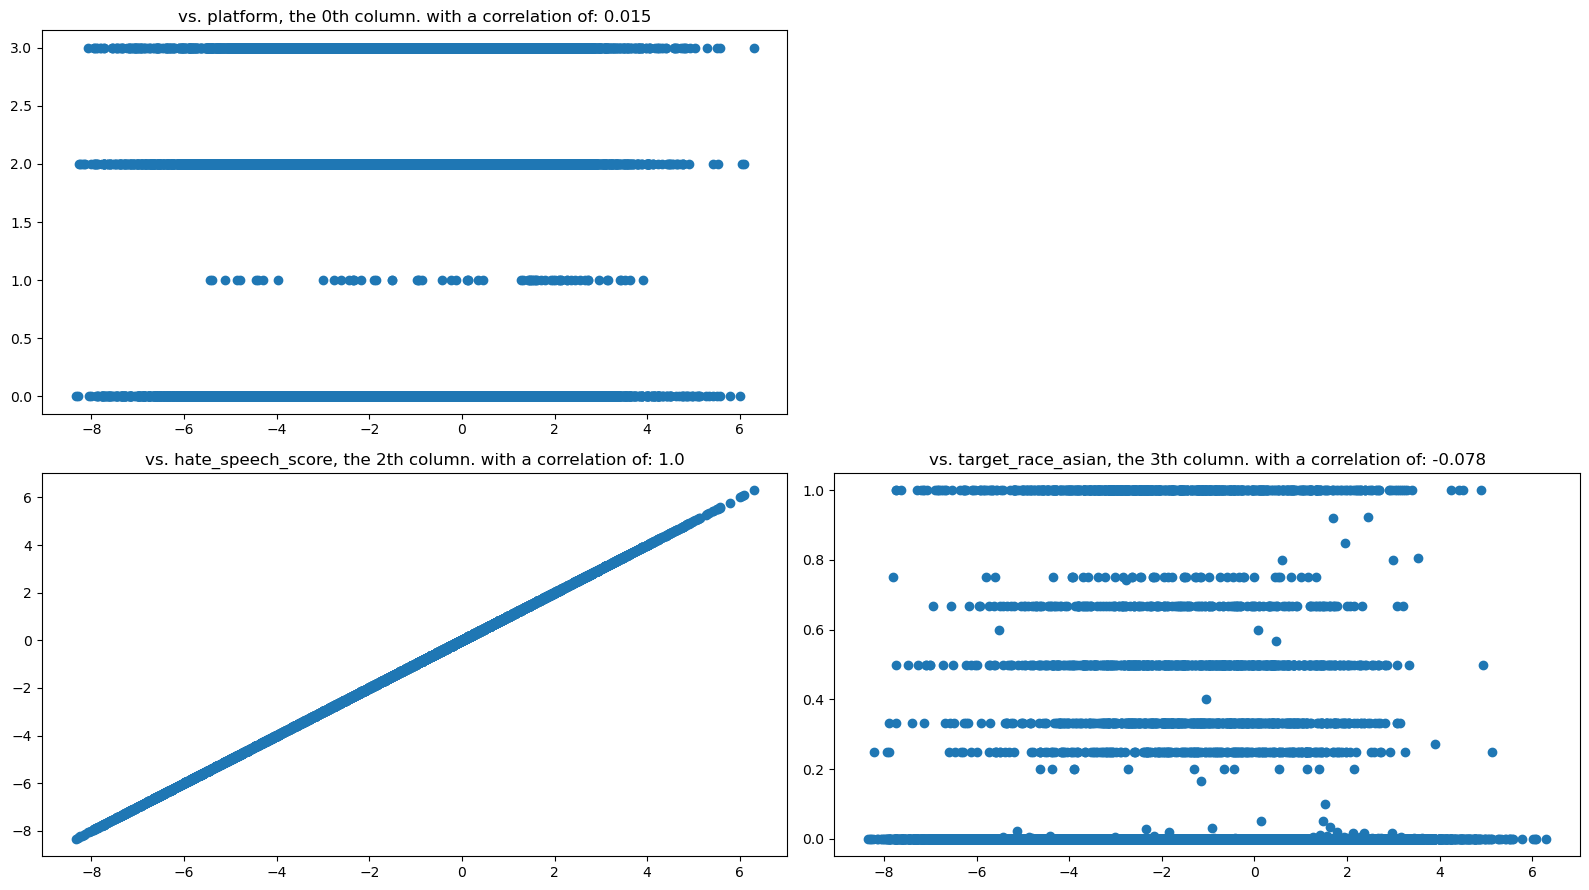

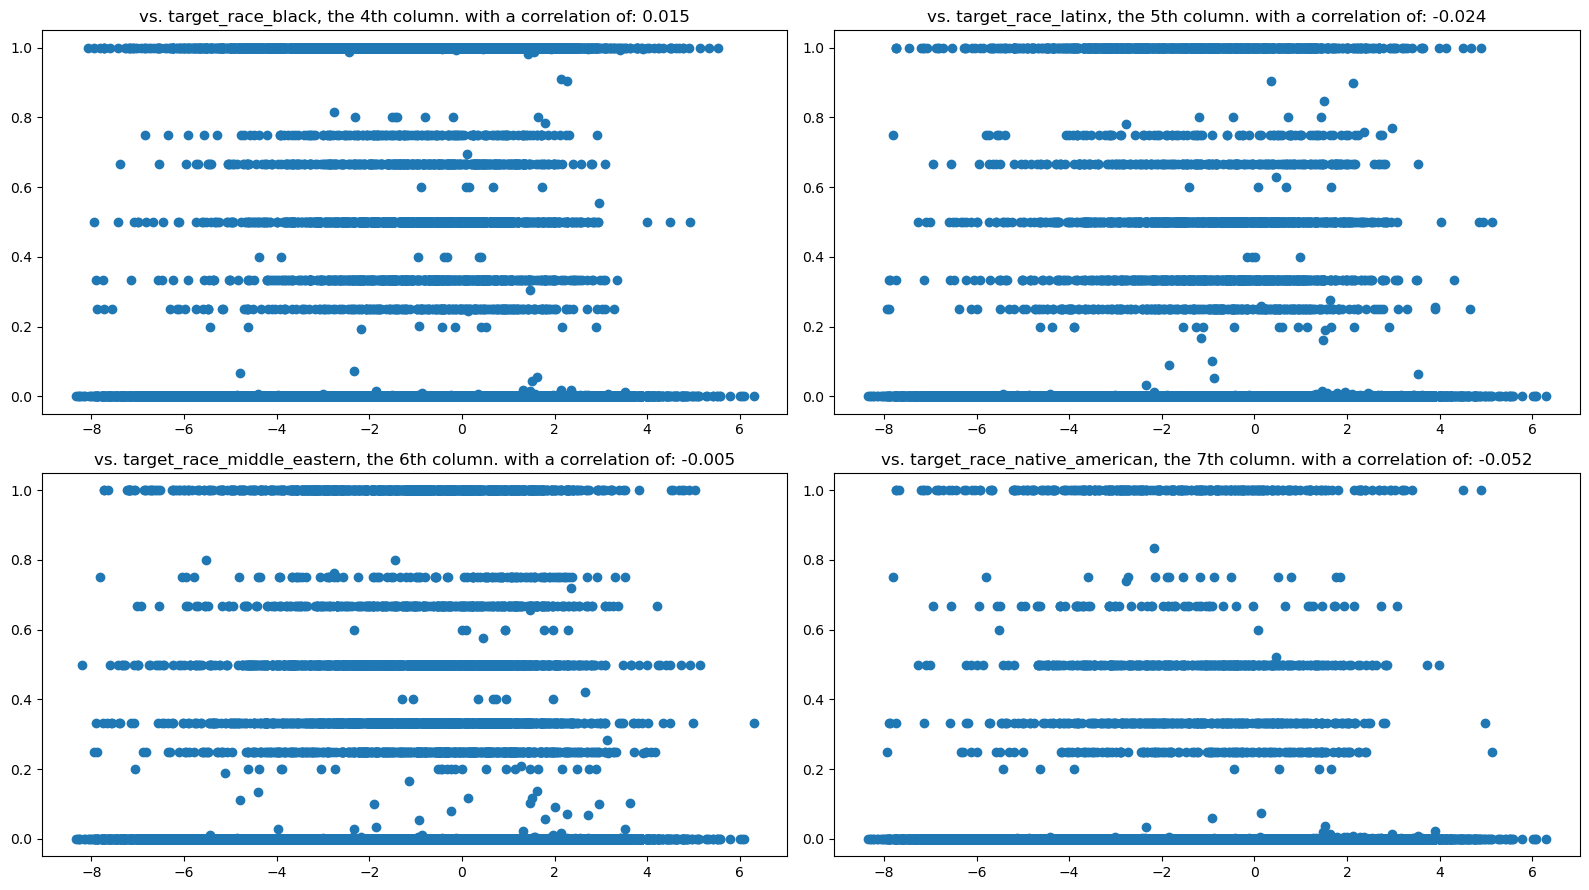

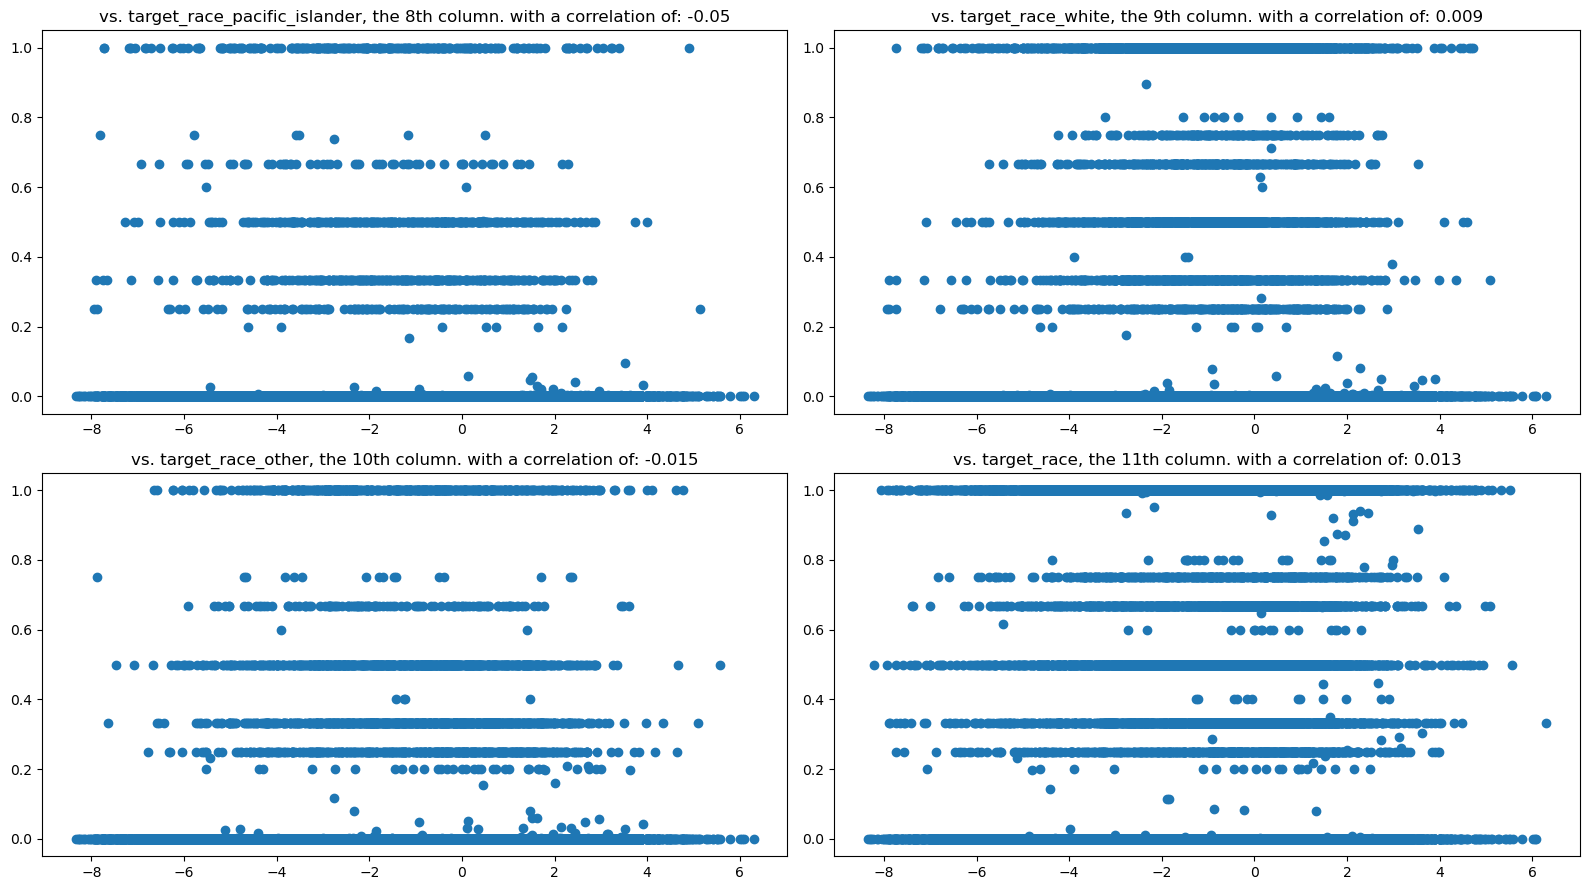

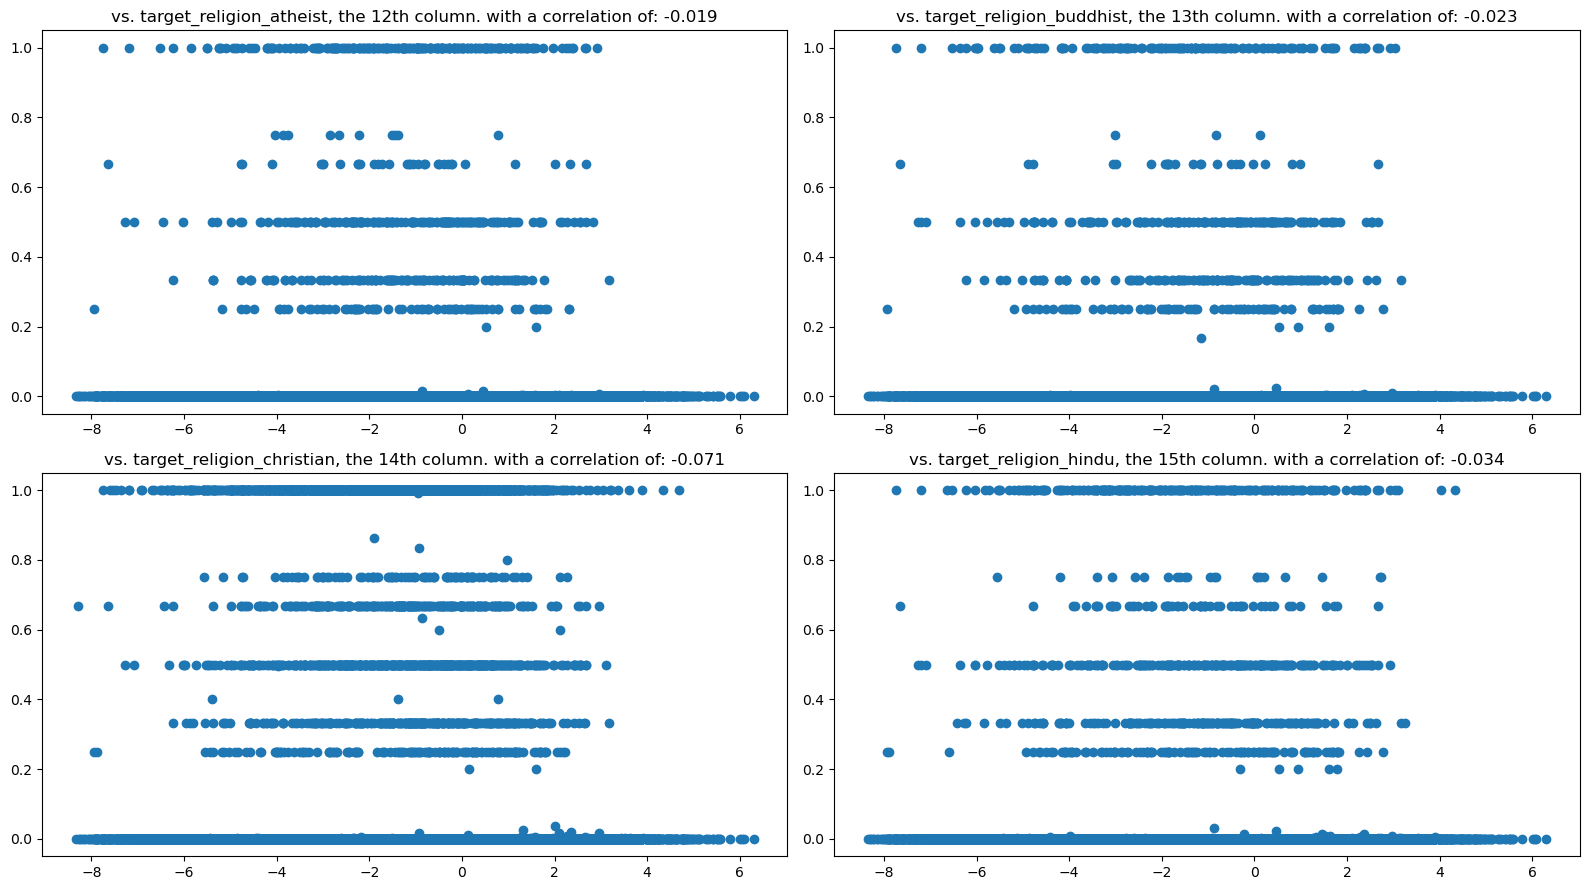

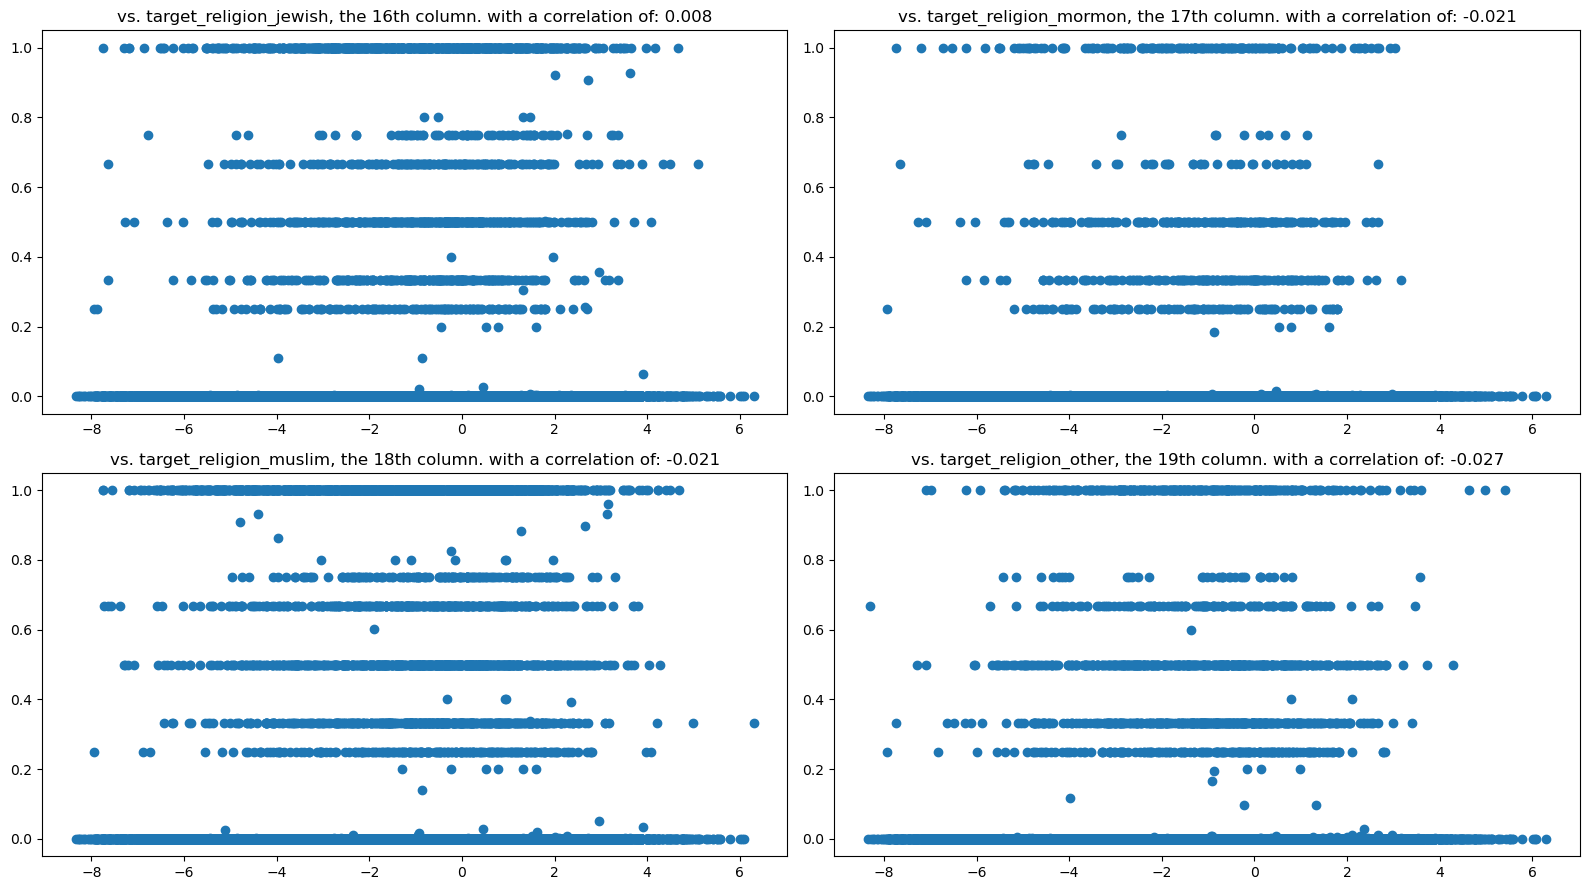

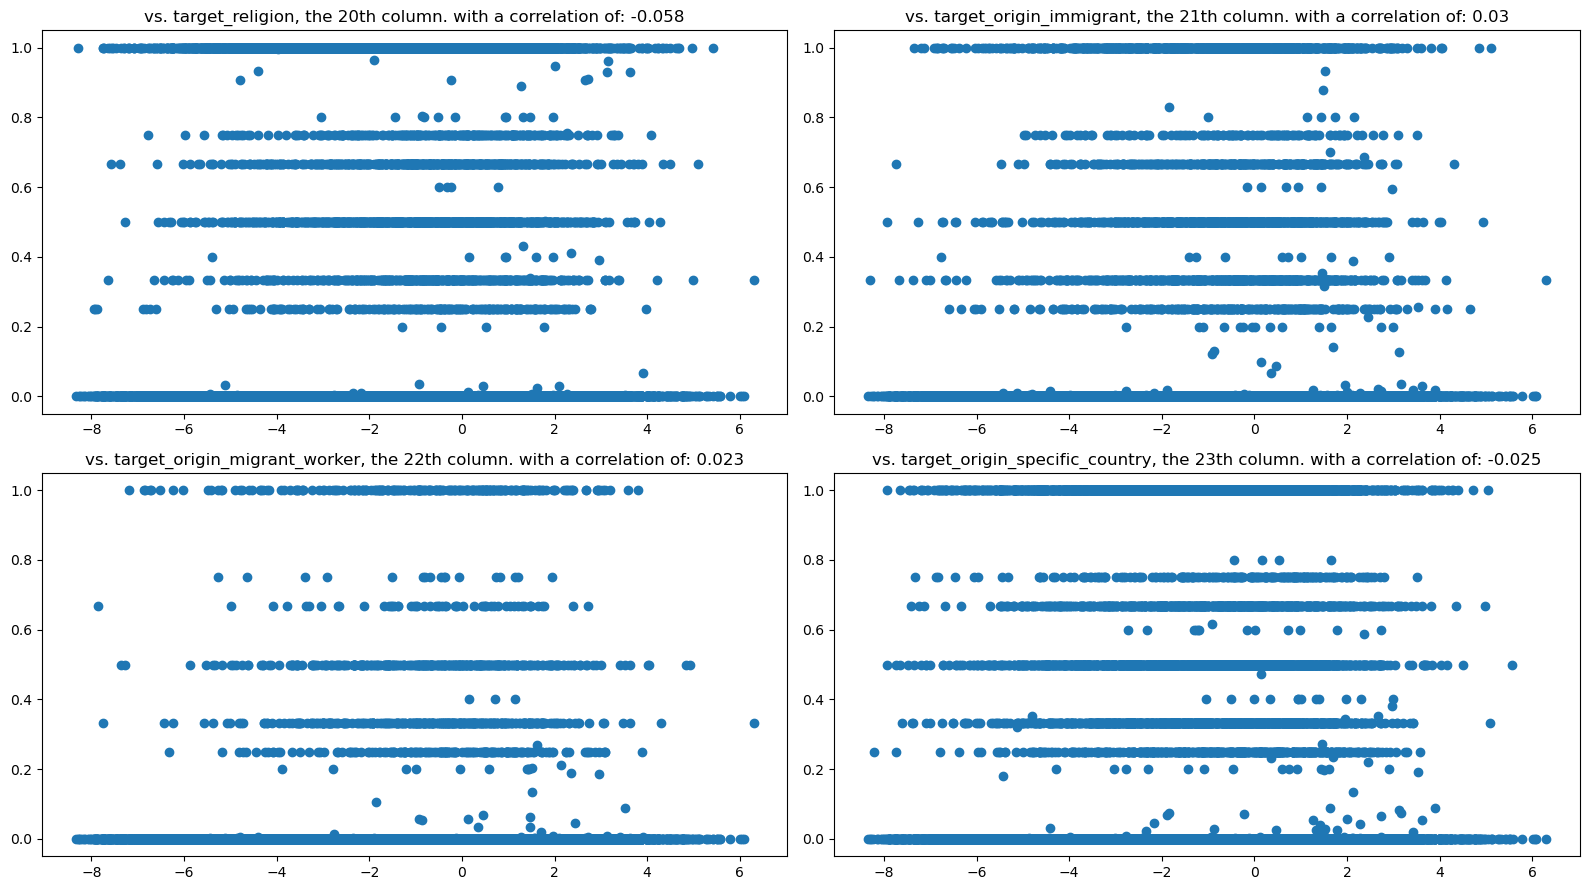

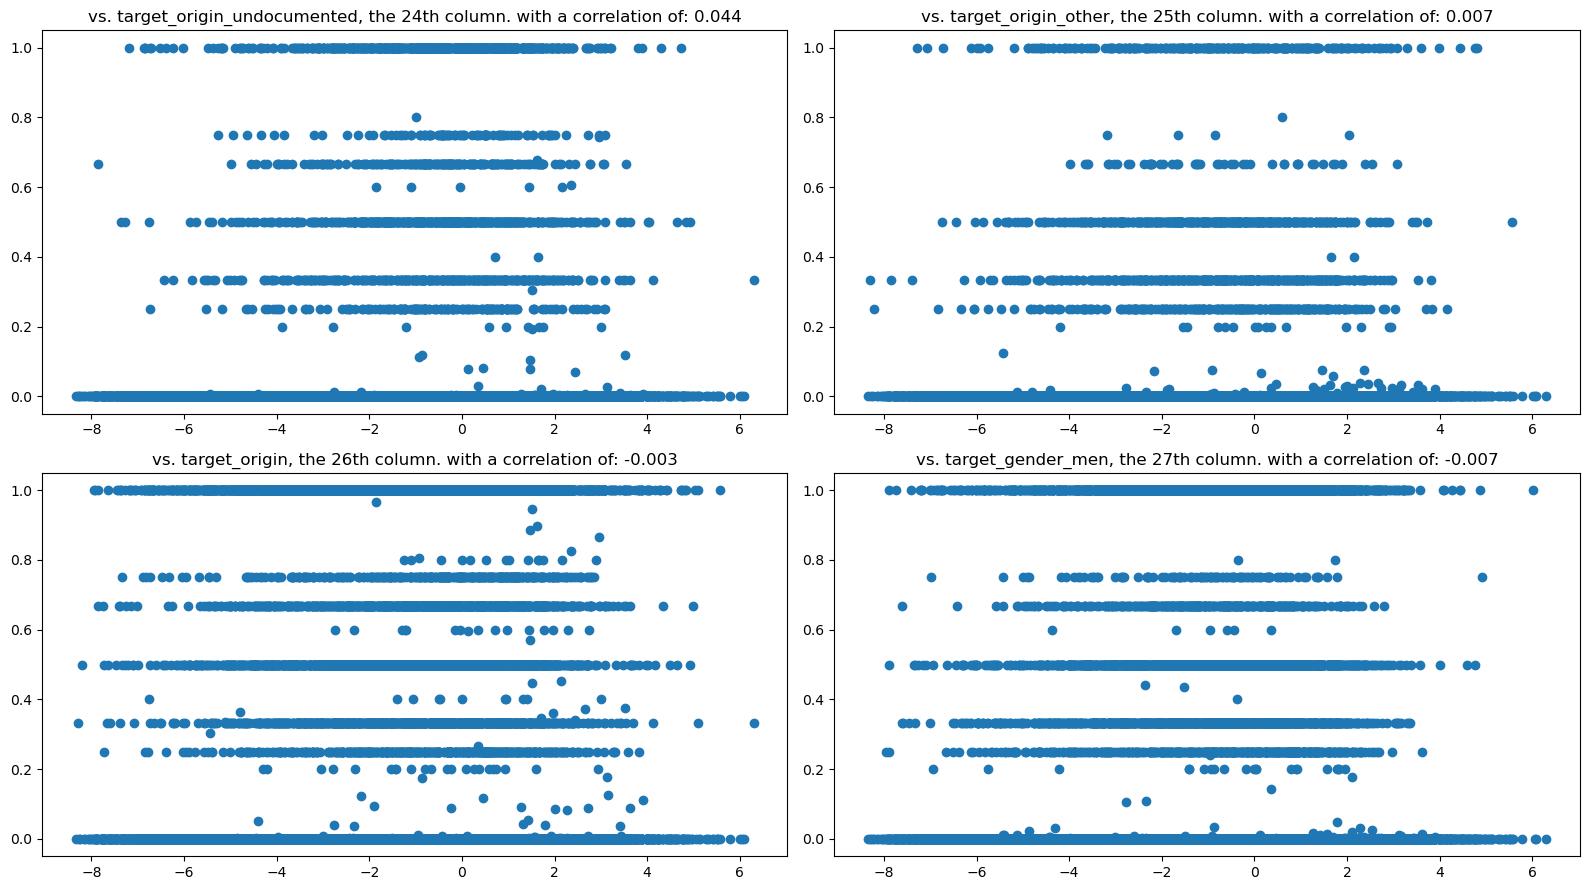

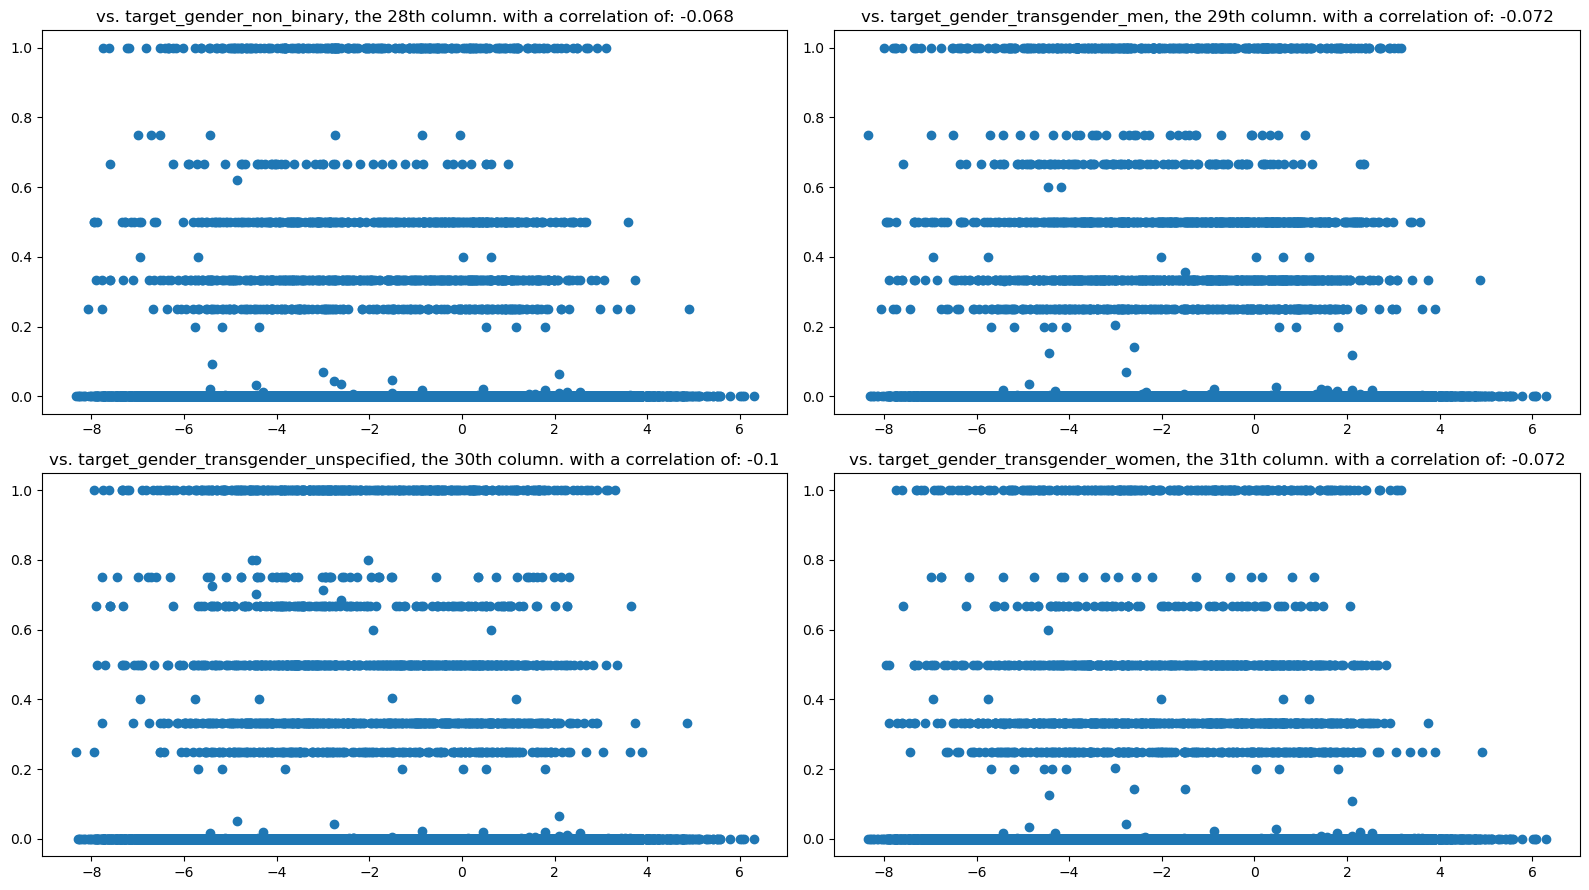

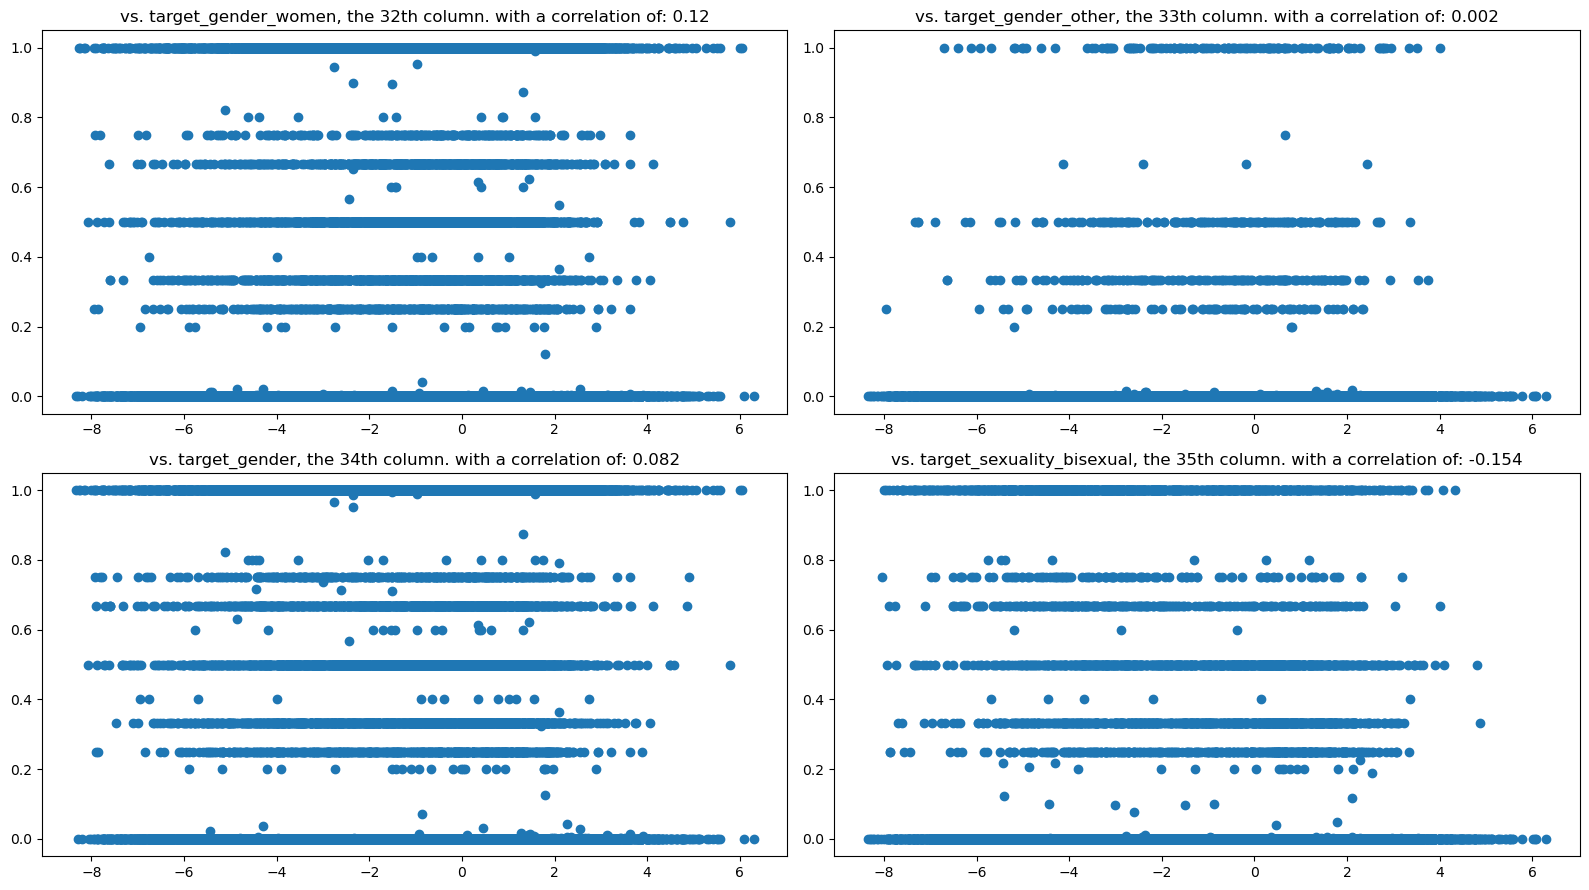

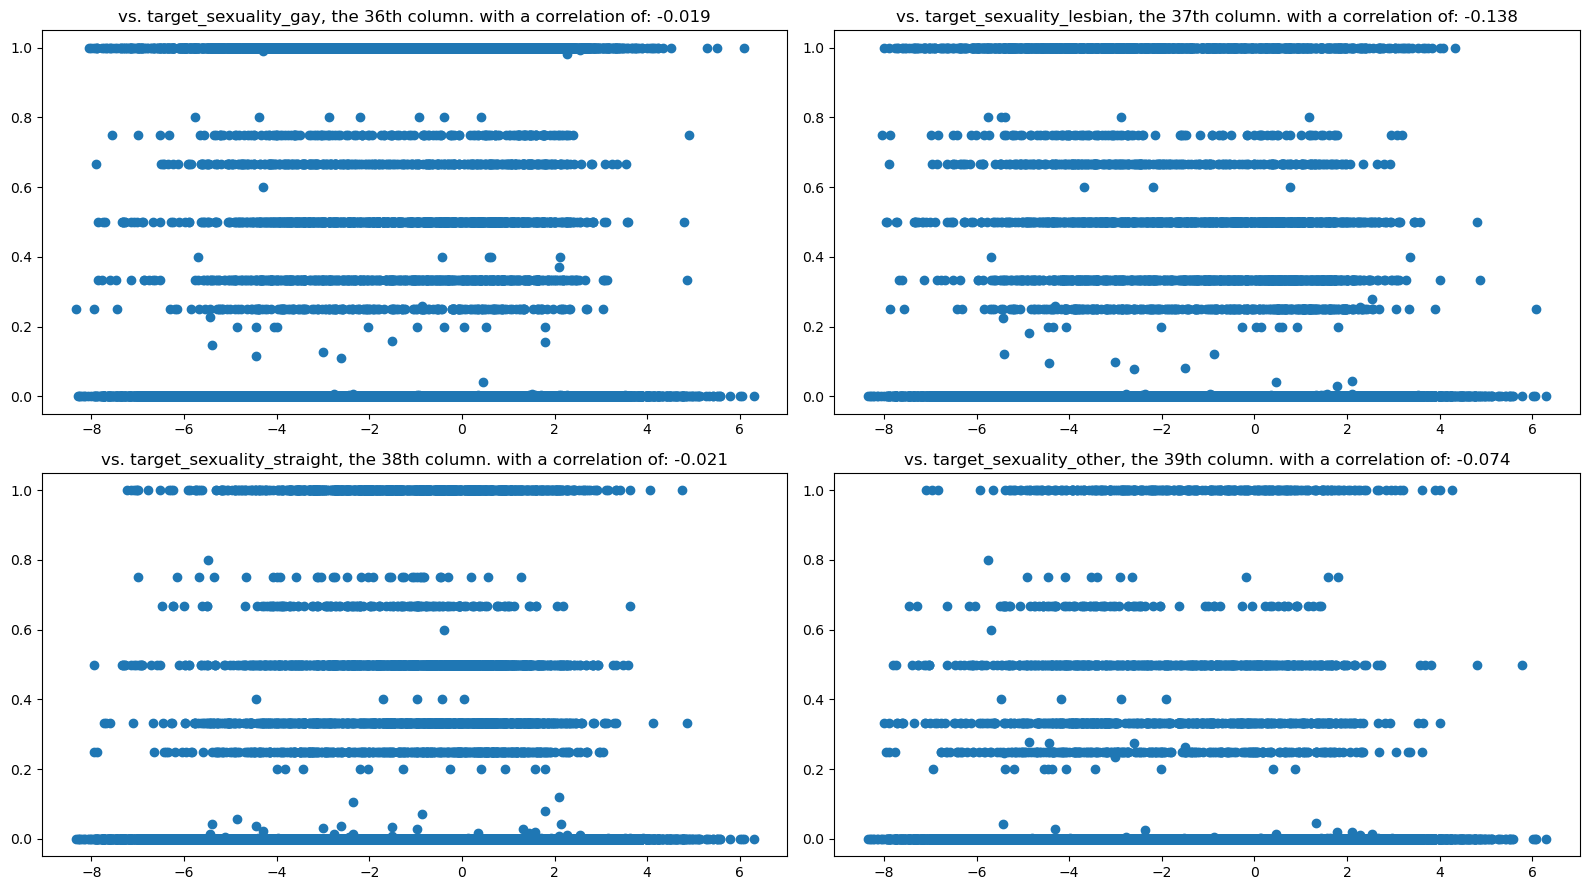

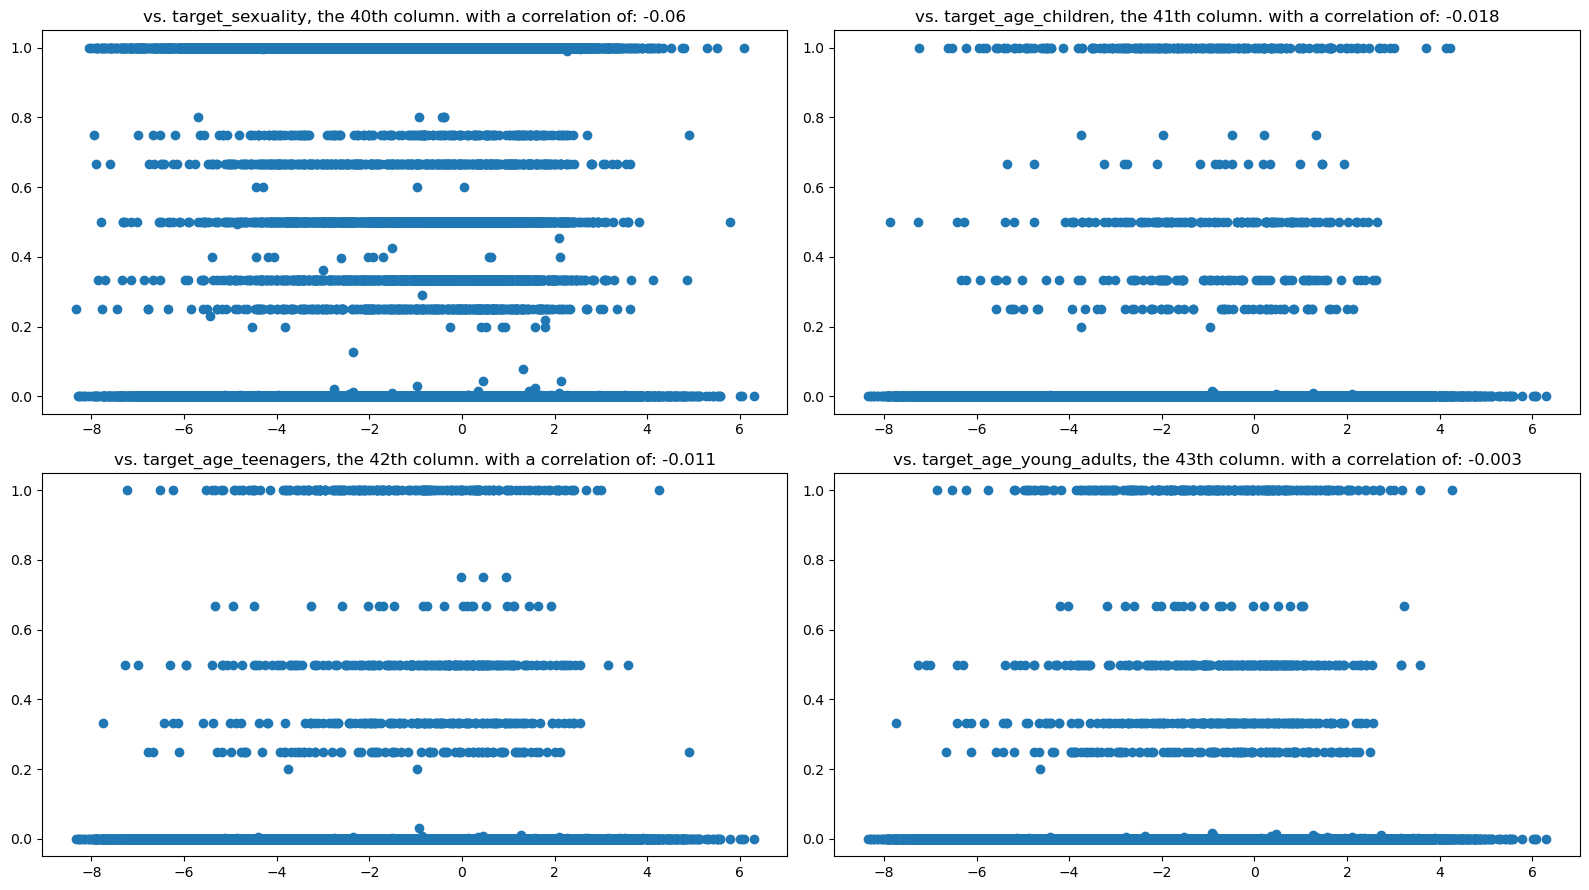

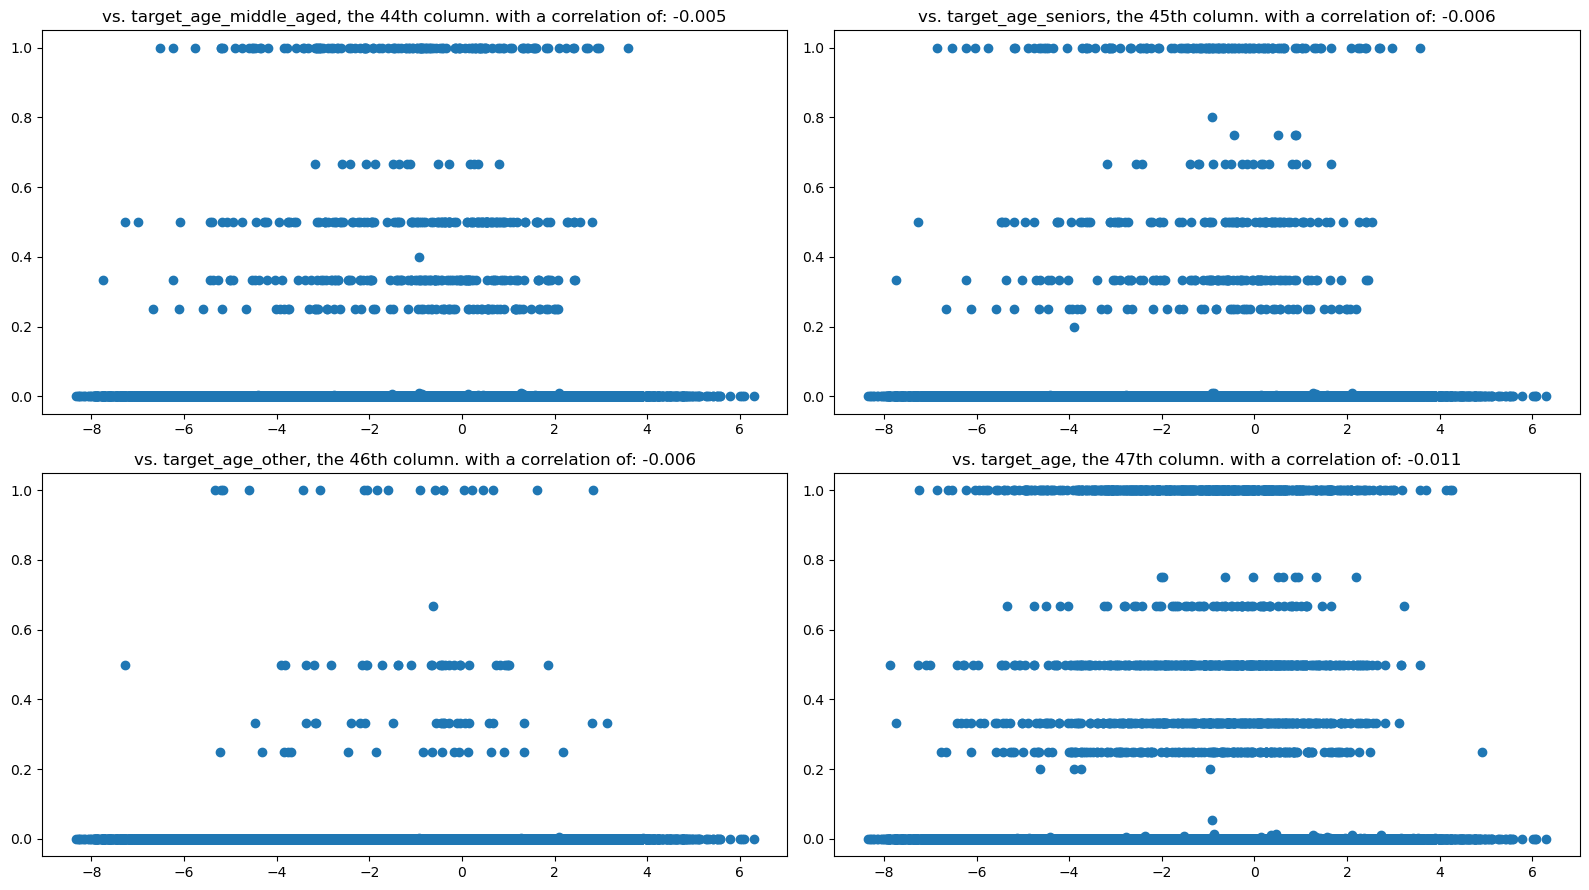

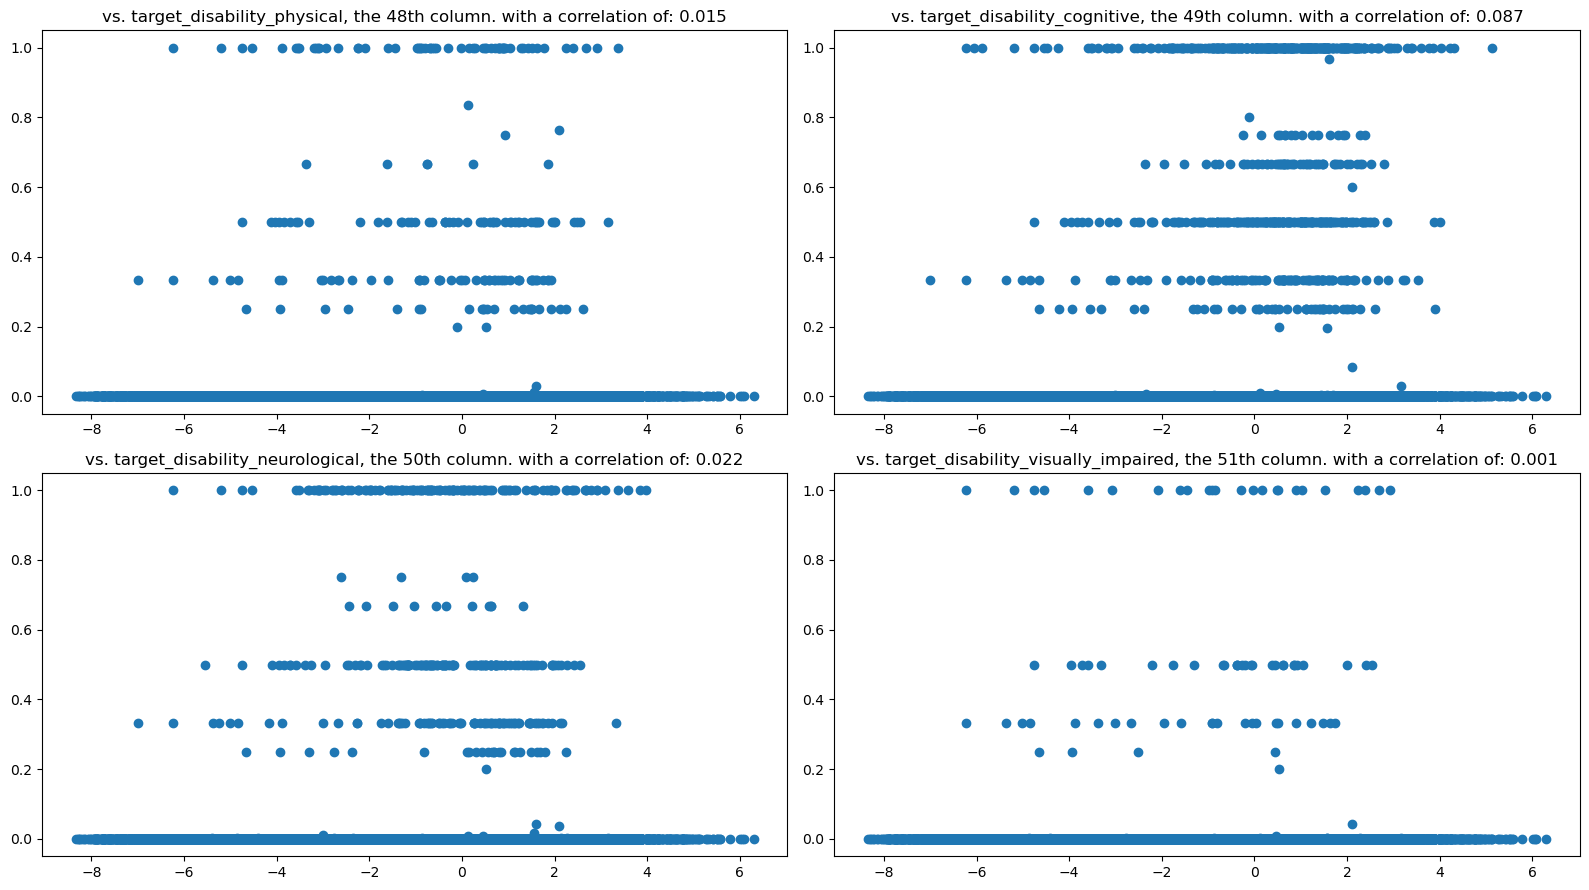

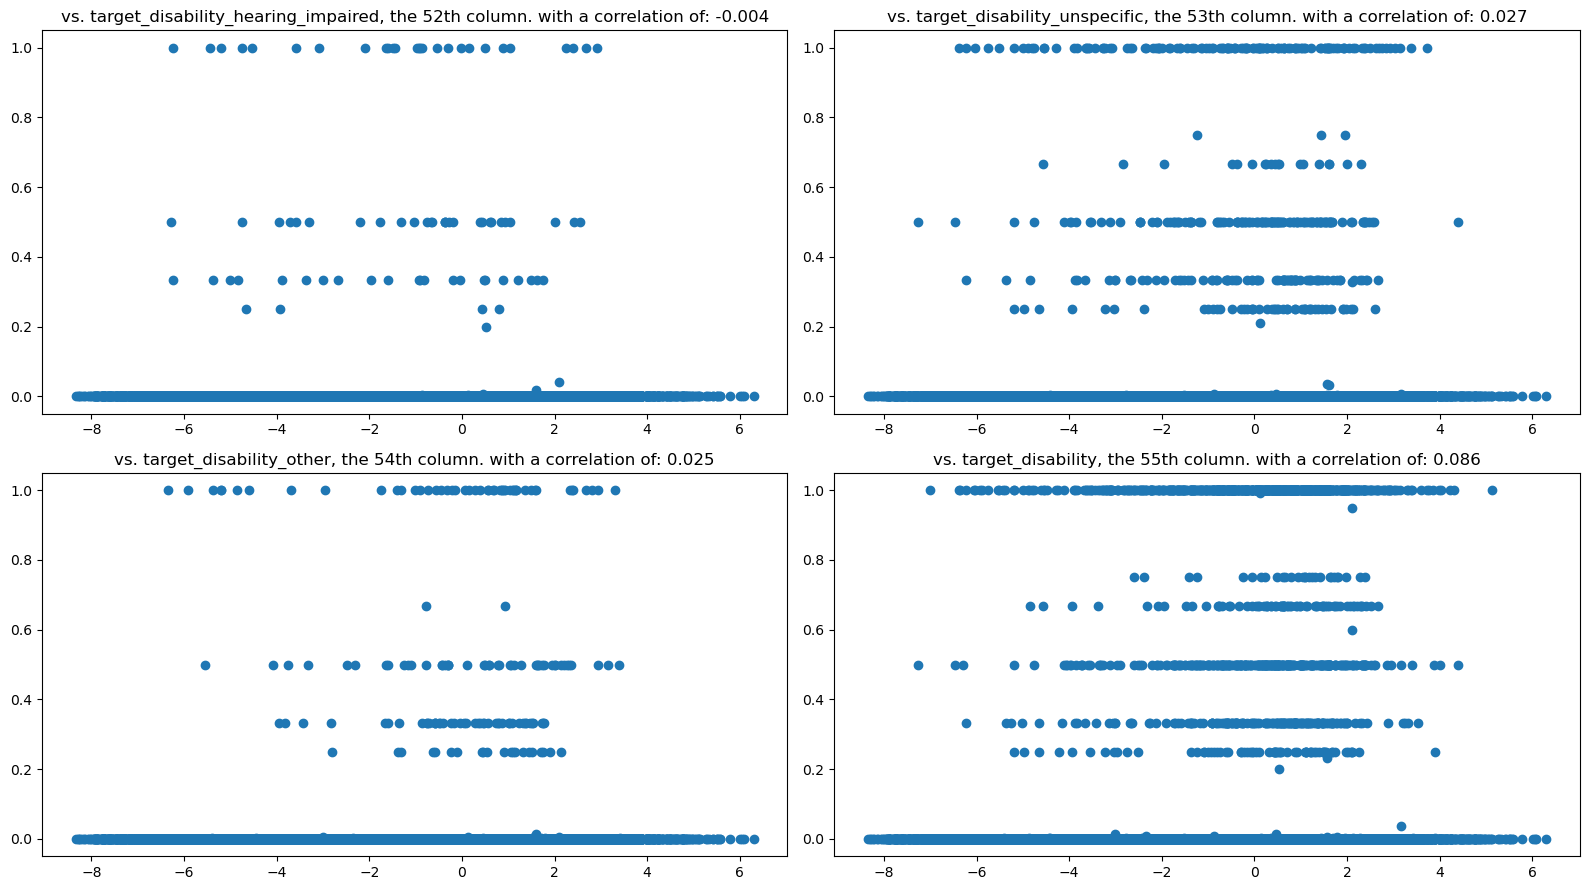

In [42]:
scatter_looker(final, 2) #Yeah, this tells me nothing... worth a try though.

In [43]:
final.groupby('hate_speech_score')['target_race'].describe() #Hmm, and I already tried things the other way... Guess we'll lave
#things as is for now. Hmm, so what now?

,count,mean,std,min,25%,50%,75%,max
hate_speech_score,,,,,,,,
-8.34,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
-8.30,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
-8.28,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
-8.24,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
-8.21,1.0,0.500000,NaN,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...
5.78,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
6.01,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
6.05,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
final.head()

,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
comment_id,,,,,,,,,,,,,,,,,,,,,
1,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#I suppose now we can make our proxy columns; hmm, do it in the next notebook? Eh, yeah, we'll do it in the next notebook.

#I suppose until here for now.

## Commented out in case something happens.
# final.to_csv('data/cleaned_02_i.csv', index=False) #Hmm, do I care about preserving the original comment? Eh, for simplicity


#I won't bother any more. I might regret this later... oh well.

In [ ]:
df = pd.read_csv('data/cleaned_02_i.csv')
print(df.shape)
df.head()